## Projeto 2 - Ciência dos Dados

Felipe Schiavinato e Jerônimo de Abreu Afrange

### Uma análise do sistema Helium: criptotokens e internet das coisas

**Questão central:** quanto rende um hotspot em 2021?

In [52]:
import pandas as pd
import numpy as np
import json
import math

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import expon
from sklearn import metrics


### Introdução

O objeto de análise em questão é a rede Helium. A rede Helium é um sistema decentralizado baseado na tecnologia Blockchain que tem como objetivo incentivar e promover a disseminação de infraestrutura de IoT (internet das coisas). O modo a partir do qual isso é feito é pela distribuição de recompensas, em forma de criptotokens (ativos digitais semelhantes à criptomoedas), para todos aqueles que instalarem roteadores de LoRa (tecnologia de conectividade sem fio de baixa energia e longo alcance) e aumentarem a área de cobertura do sistema.

O objetivo da análise é responder à pergunta:

**Quanto rende um hotspot em 2021?**

Para isso, deve-se entender um pouco mais do sistema de recompensas da rede Helium. O sistema de recompensas funciona a partir das três tarefas essenciais desempenhadas pelos hotspots:
* Comprovação de cobertura;
* Atualização do Blockchain (mineração);
* Interfaceamento de dados.

Atualmente, as recompensas por comprovação de cobertura compõem a vasta maioria dos ganhos, portanto, serão desconsiderados os fatores que influenciam os ganhos a partir dos dois demais meios de recompensa. Apenas fatores que influenciam os processos de comprovação de cobertura serão considerados.

**O que é comprovação de cobertura?**

Um dos objetivos do sistema como um todo é disseminar conectividade de baixo custo energético ao redor do mundo. Todos os hotspots inclusos na rede têm sua localização registrada no sistema, tendo em mente identificar onde a rede está, ou não, implementada. A comprovação de cobertura é um papel essencial do sistema, e é desempenhado por todos os hotspots. A função do processo é verificar se a cobertura de fato existe naquele local.

Por exemplo, um hotspot qualquer está incluso no sistema, como verificar se ele está, de fato, transmitindo e recebendo dados por meio do protocolo LoRa? A fim de verificar se ele está transmitindo, o sistema, repetidamente solicita que ele transmita dados específicos (inacessíveis aos demais hotspots) para todos os demais hotspots proximos; esses, se receberem esses dados, enviam os dados ao sistema, comprovando que o tal hotspot está de fato transmitindo. A fim de verificar se ele está recebendo, o processo é o mesmo, mas nesse caso um hotspot próximo transmite, e ele recebe.

Recompensas são dadas ao hotspot em ambos os casos. Quando demais hotspots testemunham suas transmissões de teste, e, também, quando ele testemunha transmissões de teste de demais hotspots.

A partir desse mecanismo de recompensa, identifica-se uma variável que influencia fortemente o retorno de um hotspot: a quantidade de demais hotspots próximos a ele. A fim de evitar complexidade, esse será a única variável considerada.

### Obtenção dos dados
Os dados utilizados nessa análise foram obtidos a partir da API do sistema Helium. Os processos de coleta, formatação e armazenamento dos dados estão definidos no script *data_scraper.py*, incluso no repositório.

### Manipulação dos dados

**- Primeiro passo: carregamento dos dados**

Nesse passo, serão carregados os dados obtidos a partir da API da rede Helium. Estes estão inclusos no repositório dentro do arquivo *dados.json*.

In [53]:
# carregamento dos dados do arquivo JSON
with open('dados.json') as file:
    dados = json.load(file)['dados']

# seleção e renome dos dados relevantes
dados = pd.DataFrame(dados).loc[:, ['hotspots proximos', 'por dia']]
dados = dados.rename(columns = {'hotspots proximos': 'x', 'por dia': 'y'})

O `pandas.DataFrame` `dados` contém o número de hotspots próximos e valor médio de retorno diário de quase todos os roteadores atualmente instalados no sistema.

Os gráficos seguintes ilustram a distribuição de probabilidade de retorno diário médio e a de quantidade de hotspots próximos.

/Users/jeronimo/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jeronimo/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


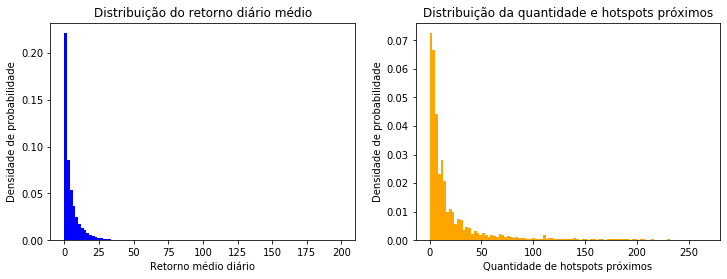

In [54]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(dados['y'], color='blue', bins=100, density=True)
plt.title('Distribuição do retorno diário médio')
plt.xlabel('Retorno médio diário')
plt.ylabel('Densidade de probabilidade')

plt.subplot(1,2,2)
plt.hist(dados['x'], color='orange', bins=100, density=True)
plt.title('Distribuição da quantidade e hotspots próximos')
plt.xlabel('Quantidade de hotspots próximos')
plt.ylabel('Densidade de probabilidade')

plt.show()


O gráfico a seguir ilustra a relação entre a quantidade de hotspots próximos e o retorno diário médio.

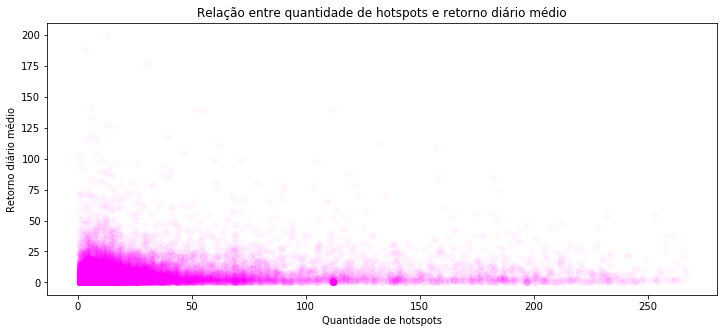

In [55]:
plt.figure(figsize=(12,5))

plt.subplot(1,1,1)
plt.scatter(dados['x'], dados['y'], color='magenta', alpha=0.025)
plt.title('Relação entre quantidade de hotspots e retorno diário médio')
plt.ylabel('Retorno diário médio')
plt.xlabel('Quantidade de hotspots')

plt.show()

**- Segundo passo: cálculo da reta de tendência com parte dos dados**

Parte dos dados disponíveis serão utilizados para determinar os coeficientes linear e angular da linha de tendência, estes serão denominados `dados_treinamento`.

O restante dos dados disponíveis será utilizado para medir a verossimilhança dos valores teóricos obtidos a partir da linha de tendência. Esses serão denominados `dados_validacao`.

In [56]:
# eliminação dos valores vazios para qtde. de hotspots
filtro = pd.notnull(dados['x'])
dados = dados.loc[filtro, :]

# eliminação dos valores vazios para retorno diário médio
filtro = pd.notnull(dados['y'])
dados = dados.loc[filtro, :]

# split de proporção entre dados de treinamento e validação
porcentagem_treinamento = 90
split_qtde = round(len(dados) * porcentagem_treinamento / 100)

# embaralhamento e separação dos dados
dados_embaralhados = dados.sample(frac=1)
dados_embaralhados_validacao = dados_embaralhados.iloc[split_qtde:, :]
dados_embaralhados_treinamento = dados_embaralhados.iloc[:split_qtde, :]
dados_treinamento = dados_embaralhados_treinamento.sort_values(by=['x'])
dados_validacao = dados_embaralhados_validacao.sort_values(by=['x'])

# cáclulo dos coeficientes linear e angular (coeficientes = [angular, linear])
coeficientes = np.polyfit(np.array(dados_treinamento['x']), np.array(dados_treinamento['y']), 1)

# 'função' da linha de tendência
linha_tendencia = np.poly1d(coeficientes)


Fórmula da linha de tendência:

In [57]:
print('y ~= %.3fx + %.3f' % (coeficientes[0], coeficientes[1]))

y ~= 0.031x + 4.801


O gráfico a seguir mostra os dados de treinamento e a linha de tendência obtida.

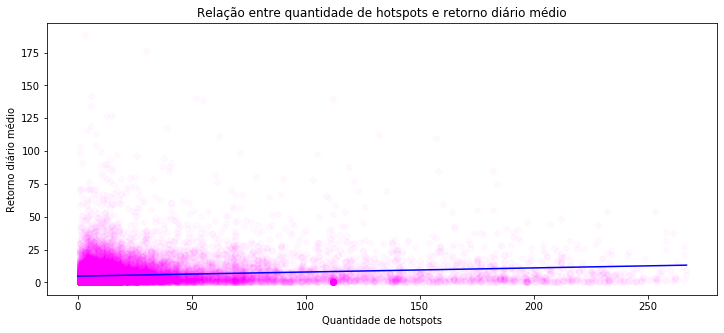

In [58]:
plt.figure(figsize=(12,5))

plt.subplot(1,1,1)
plt.scatter(dados_treinamento['x'], dados_treinamento['y'], color='magenta', alpha=0.025)
plt.plot(dados_treinamento['x'], linha_tendencia(np.array(dados_treinamento['x'])), 'blue')
plt.title('Relação entre quantidade de hotspots e retorno diário médio')
plt.ylabel('Retorno diário médio')
plt.xlabel('Quantidade de hotspots')

plt.show()

**- Terceiro passo: validação da regressão**

O primeiro método utilizado para validar a verossimilhança da linha de tendência obtida será a correlação entre os seus valores para todos os valores de `dados_validacao['x']` e os dados reais `dados_validacao['y']`.


In [59]:
# listagem dos valores da linha de tendência para cada x em dados_x_validacao
retornos_teoricos = pd.Series(linha_tendencia(dados_validacao['x']))

# cálculo da correlação
correlacao = retornos_teoricos.corr(dados_validacao['y'])


O gráfico a seguir ilustra a dispersão dos valores `retornos_teoricos` e `dados_validacao['y']`. O valor da correlação entre os dois também é mostrado abaixo.

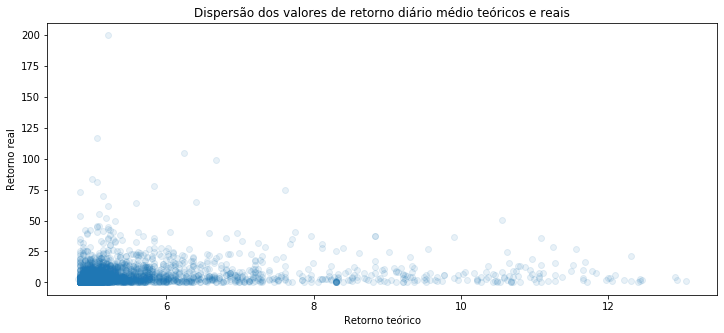

Correlação: ~10.03 %


In [60]:
plt.figure(figsize=(12,5))

plt.subplot(1,1,1)
plt.scatter(retornos_teoricos, dados_validacao['y'], alpha=0.1)
plt.title('Dispersão dos valores de retorno diário médio teóricos e reais')
plt.ylabel('Retorno real')
plt.xlabel('Retorno teórico')

plt.show()

print('Correlação: ~%.2f ' % (correlacao * 100), end='%\n')

O segundo método de validação serão os valores da variância e do desvio padrão dos erros dos valores teóricos, que serão denominados de `erros_teoricos`. Os erros são as diferenças entre os `retornos_teoricos`, obtidos a partir da linha de tendência, e os valores reais em `dados_validacao['y']`.

In [61]:
# cálculo do erro para cada valor em dados_validacao['y']
erros_teoricos = list()
erros_quadrados = list()
indice = 0
for retorno_real in dados_validacao['y']:
    retorno_teorico = retornos_teoricos[indice]
    indice += 1
    erro = retorno_teorico - retorno_real
    erros_teoricos.append(erro)
    erros_quadrados.append(erro ** 2)
    
# cálculo da variância
erros_teoricos = np.array(erros_teoricos)
variancia_erros = np.var(erros_teoricos)
desvio_padrao_erros = math.sqrt(variancia_erros)
media_retorno_real = np.mean(dados_validacao['y'])
proporcao = desvio_padrao_erros / media_retorno_real


A seguir são mostrados os valores da variância e do desvio padrão dos erros dos valores teóricos, assim como a média dos retornos diários médios reais e sua proporção em relação ao desvio padrão dos erros.

In [62]:
print('Média de retorno: ~%.2f HNT' % media_retorno_real)
print('Variância do erro: ~%.2f HNT * HNT' % variancia_erros)
print('Desvio padrão do erro: ~%.2f HNT' % desvio_padrao_erros)
print('Proporção do desvio padrão do erro em relação à média: ~%.2f' % proporcao)

Média de retorno: ~5.64 HNT
Variância do erro: ~84.47 HNT * HNT
Desvio padrão do erro: ~9.19 HNT
Proporção do desvio padrão do erro em relação à média: ~1.63


O terceiro método de validação será o valor do $\mathrm{R}^2$, que será denominado `r_quadrado`. Esse valor varia de $0$ a $1$ e representa quão bem uma regressão enquadra os dados, quanto mais próximo de $1$, melhor.

In [63]:
# cálculo do valor R^2
r_quadrado = metrics.r2_score(dados_validacao['y'], retornos_teoricos)


A seguir é mostrado o valor de $\mathrm{R}^2$.

In [64]:
print('R-quadrado: ~%.2f ' % (r_quadrado * 100), end='%\n')

R-quadrado: ~0.97 %


### Interpretação dos resultados

A partir dos valores obtidos no terceiro passo, podemos concluir que o modelo de regressão não prevê o retorno diário médio com precisão:
* Primeiro método: a correlação entre os valores teóricos e reais é extremamente baixa;
* Segundo método: o desvio padrão do erro teórico é aproximadamente 72% maior que a média real de retorno médio diário;
* Terceiro método: o valor de $\mathrm{R}^2$ é menor que 2%, o que indica baixa performance.

### Possíveis melhoras

O sistema Helium é um sistema bastante complexo, que engloba uma pletora de variáveis que influenciam o valor de retorno de cada hotspot, não apenas a quantidade de hotspots próximos.

Demais variáveis que poderiam ser levadas em conta seriam, por exemplo, a potência de transmissão do hotspot, a idade do hotspot, a quantidade total de hotspots registrados no sistema e a quantidade de LoRa nodes na região do hotspot.

A quantidade total de hotspots pode ser determinada a partir da API do sistema Helium diretamente, assim como a idade do hotspot. A potência de transmissão aproximada também, mas indiretamente.
